In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from icecream import ic

In [46]:
writer = pd.ExcelWriter("Ket qua phan loai dao ham bac 2.xlsx", engine='xlsxwriter')

In [47]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Mua(102)")
data.head(5)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,22.1.8.Qna-01,2,0.271000,0.147,6.695,0.237,0.237,0.235,0.233,...,0.032,0.031,0.031,0.032,0.033,0.032,0.032,0.031,0.030,0.030
1,2,22.1.8.Qna-03,2,0.251000,0.068,3.593,0.178,0.176,0.173,0.171,...,0.034,0.033,0.033,0.034,0.035,0.034,0.034,0.034,0.033,0.033
2,3,22.1.8.Qna-05,2,0.453000,0.068,3.575,0.182,0.183,0.180,0.177,...,0.033,0.032,0.033,0.034,0.035,0.034,0.034,0.033,0.032,0.032
3,4,22.1.8.Qna-07,2,0.730000,0.100,6.050,0.273,0.270,0.267,0.264,...,0.004,0.003,0.003,0.004,0.005,0.004,0.004,0.002,0.002,0.002
4,5,22.1.8.Qna-08,2,0.200507,0.098,4.202,0.228,0.226,0.224,0.222,...,0.032,0.031,0.031,0.032,0.033,0.033,0.032,0.031,0.031,0.030


In [48]:
y = data["Group"]
le = LabelEncoder()
y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
print(np.unique(y))
print(le.inverse_transform(np.unique(y)))

[0 1]
[2 5]


In [49]:
X = savgol_filter(X, window_length=25, polyorder=5, deriv=2)

In [50]:
X = pd.DataFrame(X, columns=cols)

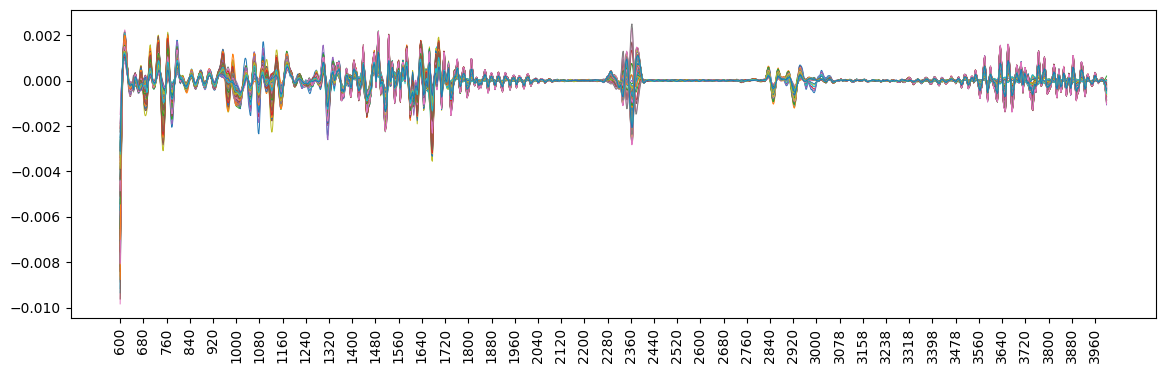

In [51]:
plt.figure(figsize=(14, 4))
plt.plot(X.T, linewidth= 0.7)
plt.xticks(X.columns[::40], rotation=90)
plt.show()

### Train test split

In [52]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (77, 1701) (77,)
Validation set shape: (24, 1701) (24,)


In [53]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [55]:
np.random.seed(0)
res = {}

PCA-SVC

ic| grid.best_params_: {'pca__n_components': 7, 'svc__kernel': 'linear'}




Accuracy score: 0.9583333333333334


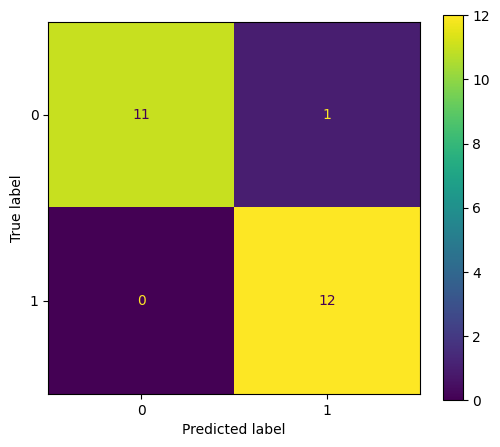

In [56]:
pca = PCA()
svc = SVC()
pipeline = Pipeline(steps=[('pca', pca), ('svc', svc)])
param_grid = {
    'pca__n_components': np.arange(1,42),
    'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-GaussNB

ic| grid.best_params_: {'pca__n_components': 31}




Accuracy score: 0.9166666666666666


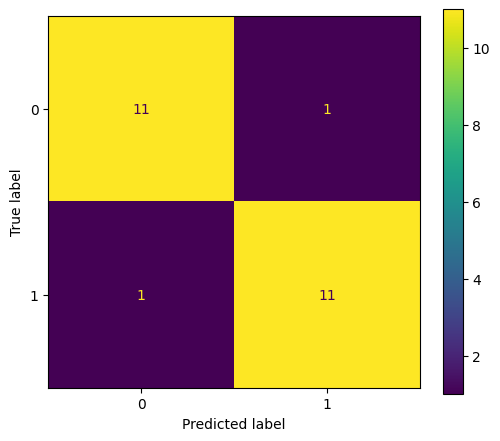

In [57]:
pca = PCA()
gauss_nb = GaussianNB()
pipeline = Pipeline(steps=[('pca', pca), ('gauss', gauss_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-BernouliNB

ic| grid.best_params_: {'pca__n_components': 21}




Accuracy score: 0.9166666666666666


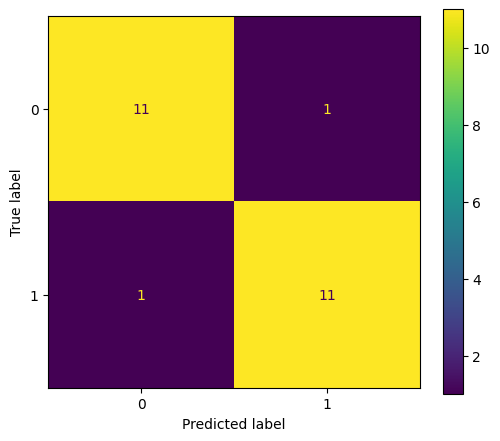

In [58]:
pca = PCA()
ber_nb = BernoulliNB()
pipeline = Pipeline(steps=[('pca', pca), ('ber', ber_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-RF

ic| grid.best_params_: {'pca__n_components': 15}




Accuracy score: 1.0


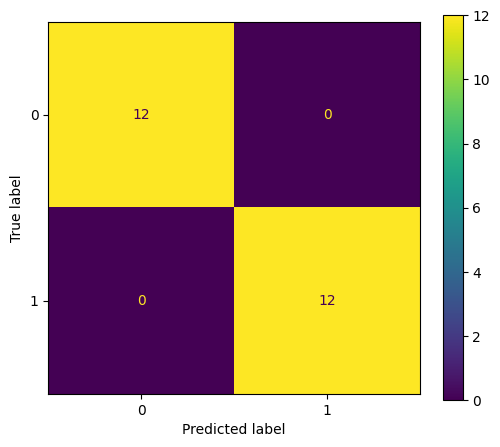

In [59]:
pca = PCA()
rf = RandomForestClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('rf', rf)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-DT

ic| grid.best_params_: {'pca__n_components': 8}




Accuracy score: 0.9583333333333334


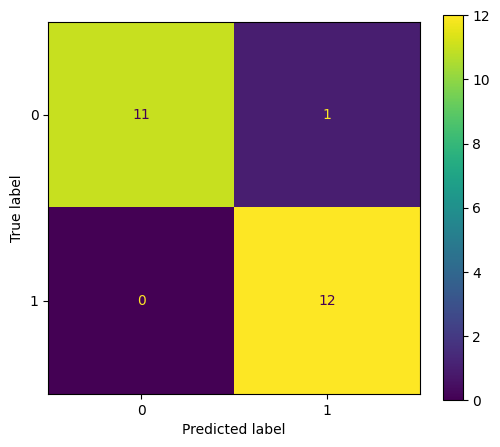

In [60]:
pca = PCA()
dt = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('dt', dt)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-AdaBoost

c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boos

c:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy score: 0.9583333333333334


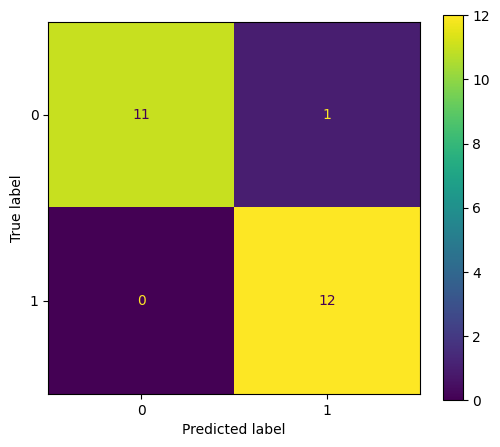

In [61]:
pca = PCA()
ada = AdaBoostClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('ada', ada)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-GradientBoost

ic| grid.best_params_: {'pca__n_components': 19}




Accuracy score: 0.9166666666666666


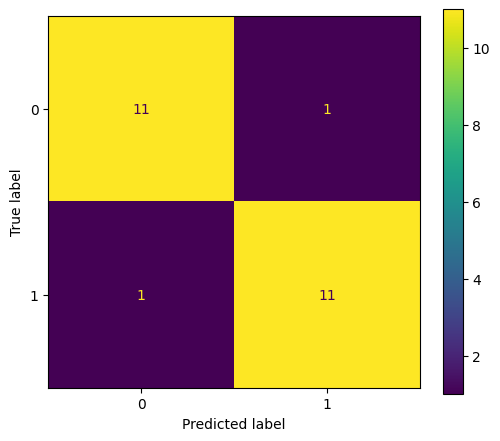

In [62]:
pca = PCA()
grad_boost = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('grad_boost', grad_boost)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

In [63]:
writer.close()

In [64]:
res

{'PCA-SVC': 0.9583333333333334,
 'PCA-GaussianNB': 0.9166666666666666,
 'PCA-BernoulliNB': 0.9166666666666666,
 'PCA-RandomForestClassifier': 1.0,
 'PCA-DecisionTreeClassifier': 0.9583333333333334,
 'PCA-AdaBoostClassifier': 0.9583333333333334,
 'PCA-GradientBoostingClassifier': 0.9166666666666666}